# Comparing Bandit Agents

The notebook (`compare.ipynb`) compares the performance of different bandit agents. The `compare.py` script is for command-line execution. They are automatically paired using `jupytext -s`. 

### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, sys
from typing import List
import multiprocessing

cores =  multiprocessing.cpu_count() - 1

from bart_playground.bandit.sim_util import *
from compare_agents import (
    AgentSpec, compare_agents_across_scenarios, print_summary_results, plot_comparison_results,
    _ca_logger
)
# from bart_playground.bandit.rome.rome_scenarios import HomogeneousScenario, NonlinearScenario

In [2]:
from bart_playground.bandit.bcf_agent import BCFAgent, BCFAgentPSOff
from bart_playground.bandit.basic_agents import SillyAgent, LinearTSAgent
from bart_playground.bandit.ensemble_agent import EnsembleAgent
from bart_playground.bandit.me_agents import HierTSAgent, LinearTSAgent2, LinearUCBAgent, METSAgent
from bart_playground.bandit.bart_agent import BARTAgent, LogisticBARTAgent, DefaultBARTAgent, MultiChainBARTAgent
from bart_playground.bart import DefaultBART, LogisticBART
# from bart_playground.bandit.neural_ts_agent import NeuralTSDiagAgent

## Tunable Parameters

In [3]:
# Create test scenarios
scenario_factories = {
    # "Linear": lambda: LinearScenario(P=4, K=3, sigma2=1.0),
    # "LinearOffset": lambda: LinearOffsetScenario(P=4, K=3, sigma2=1.0),
    # "Offset": lambda: OffsetScenario(P=4, K=3, sigma2=1.0),
    # "Offset2": lambda: OffsetScenario(P=4, K=3, sigma2=0.1),
    # "Friedman": lambda: FriedmanScenario(P=5, K=3, sigma2=1.0, lambda_val=15),
    # "Sparse": lambda: FriedmanScenario(P=50, K=3, sigma2=1.0, lambda_val=5),
    ## "Isolet": lambda: OpenMLScenario('isolet', version=1),
    "Magic": lambda: OpenMLScenario('MagicTelescope', version=1),
    "Adult": lambda: OpenMLScenario('adult', version=2),
    "Shuttle": lambda: OpenMLScenario('shuttle', version=1),
    ## "Letter": lambda: OpenMLScenario('letter', version=1),
    "Mushroom": lambda: OpenMLScenario('mushroom', version=1),
    "Covertype": lambda: OpenMLScenario('covertype', version=3),
    "MNIST": lambda: OpenMLScenario('mnist_784', version=1),
}

# Parse command-line arguments
args = sys.argv[1:]
cli = True

# Determine which scenarios to run; default to Mushroom if none or invalid
if len(args) == 0 or not any(arg in scenario_factories for arg in args):
    print("No valid scenarios specified, using Mushroom.")
    args = ['Mushroom']
    cli = False

selected_keys = [k for k in scenario_factories if k in args]
scenarios = {key: scenario_factories[key]() for key in selected_keys}

rep_dataset = selected_keys[0]
log_encoding = 'native' if rep_dataset in ['Adult', 'Magic', 'Mushroom'] else 'multi' 

# import torch
# torch.manual_seed(0)
# torch.cuda.manual_seed_all(42)

No valid scenarios specified, using Mushroom.


In [4]:

all_agent_specs: List[AgentSpec] = [
    ("BCF",        BCFAgent,        {'nskip':100, 'ndpost':100, 'nadd':3, 'nbatch':1, 'random_state':1000}),
    ("BART",       DefaultBARTAgent,       {
        'n_trees': 100,
        'nskip':50,  
        'ndpost':50, 
        'nadd':2,               
        'random_state':1000}),
    ("BARTs",       DefaultBARTAgent,       {
        'n_trees': 50,
        'nskip':50,  
        'ndpost':50, 
        'nadd':2,               
        'random_state':1000,
        'encoding': 'separate'}),
    ("BARTm",       DefaultBARTAgent,       {
        'n_trees': 50,
        'nskip':50,  
        'ndpost':50, 
        'nadd':2,               
        'random_state':1000,
        'encoding': 'multi'}),
    ("LogisticBARTs", LogisticBARTAgent, {
        'n_trees': 50,
        'nskip':50,
        'ndpost':50,
        'nadd':2,
        'random_state':1000,
        'encoding': 'separate'
    }),
    ("LogisticBARTm", LogisticBARTAgent,{
        'n_trees': 50,
        'nskip':50,
        'ndpost':50,
        'nadd':2,
        'random_state':1000,
        'encoding':'multi'
    }),
    ("MCBART",     MultiChainBARTAgent,{
        'bart_class': DefaultBART,
        'n_ensembles': 3,
        'n_trees': 100,
        'nskip': 50,
        'ndpost': 50,
        'nadd': 2,
        'random_state': 1000,
        'encoding': 'multi'
    }),
    ("MCBARTs", MultiChainBARTAgent,{
        'bart_class': DefaultBART,
        'n_ensembles': 3,
        'n_trees': 50,
        'nskip': 50,
        'ndpost': 50,
        'nadd': 2,
        'random_state': 1000,
        'encoding': 'multi'
    }),
    ("MCBART3", MultiChainBARTAgent,{
        'bart_class': DefaultBART,
        'n_ensembles': 3,
        'n_trees': 100,
        'nskip': 50,
        'ndpost': 50,
        'nadd': 3,
        'random_state': 1000,
        'encoding': 'multi'
    }),
    ("Ensemble",   EnsembleAgent,   {
        'bcf_kwargs':       dict(nskip=100, ndpost=10, nadd=2, random_state=1000),
        'linear_ts_kwargs': dict(v=1)
    }),
    ("BCF_PSOff",  BCFAgentPSOff,   {'nskip':100, 'ndpost':10, 'nadd':2, 'nbatch':1, 'random_state':1000}),
    ("LinearTS",   LinearTSAgent,   {'v':1}),
    ("LinearTS2",  LinearTSAgent2,  {}),
    # commented out for on-demand testing:
    # ("RoME",             RoMEAgent,              {'featurize':_featurize, 't_max':n_draws, 'pool_users':False}),
    # ("StandardTS",       StandardTSAgent,        {'featurize':_featurize}),
    # ("ActionCenteredTS", ActionCenteredTSAgent,  {'featurize':_featurize}),
    # ("IntelligentPooling", IntelligentPoolingAgent, {'featurize':_featurize, 't_max':n_draws}),
]

In [5]:
# Filter agents to include only those we want to test
agent_specs = [agent for agent in all_agent_specs if agent[0] in ["BARTs", "BARTm", "LogisticBARTm", "LinearTS"]]

In [6]:
n_simulations = 1  # Number of simulations per scenario
max_draws = 3000      # Number of draws per simulation

if cli:
    results_dir = "./results/compare_cli" # call from CLI
else:
    results_dir = "./results/compare_test_nb" # call from notebook
os.makedirs(results_dir, exist_ok=True)

def call_func():
    return compare_agents_across_scenarios(
        scenarios=scenarios,
        agent_specs=agent_specs,
        sim_indices=list(range(n_simulations)),
        max_draws=max_draws,
        parallel=False,
        save_dir=results_dir,
        log_to_file=True
    )

In [7]:
profile = False
if profile and not cli:
    %prun -s cumtime -D profile_clog.prof -q call_func()
    !gprof2dot -f pstats profile_clog.prof -o profile_clog.dot
    !dot -Tpng profile_clog.dot -o profile_clog.png
    pass  # For notebook, we run the function and generate a profile
else:
    results = call_func()

INFO bandit_simulator — Logging detailed information to ./results/compare_test_nb/logs.
INFO bandit_simulator — Evaluating Mushroom scenario...
INFO bandit_simulator — Sequentially running simulation.
INFO bandit_simulator — Progress: 0/1. Current sim index: 0. 
Simulating:   0%|          | 0/3000 [00:00<?, ?it/s]

Fitting initial BART model with first 10 observations...

Simulating:   0%|          | 10/3000 [00:02<14:16,  3.49it/s]

 Done.


Simulating:   1%|          | 19/3000 [00:03<06:39,  7.47it/s]

Fitting initial BART model with first 20 observations... Done.
Fitting initial BART model with first 20 observations...

Simulating:   1%|          | 22/3000 [00:11<40:00,  1.24it/s]

 Done.


Simulating: 100%|██████████| 3000/3000 [05:41<00:00,  8.78it/s]
INFO bandit_simulator — Saved results for simulation 0 of Mushroom in ./results/compare_test_nb/Mushroom_sim0_0624_1416.json.


## Summary Results

In [8]:
print_summary_results(results)


=== Mushroom Scenario ===

Final cumulative regrets (mean ± std):
  BARTs: 64.00 (±0.00)
  BARTm: 63.00 (±0.00)
  LogisticBARTm: 108.00 (±0.00)
  LinearTS: 430.00 (±0.00)

Average computation times (seconds):
  BARTs: 67.3377 (±0.0000)
  BARTm: 144.4538 (±0.0000)
  LogisticBARTm: 127.7429 (±0.0000)
  LinearTS: 0.6706 (±0.0000)



## Visualize Results

Finally, let's visualize the cumulative regret for each agent across scenarios.

In [9]:
import pickle
appendix_name = list(scenarios.keys())[0]  # Use the first scenario name as appendix
result_filename = os.path.join(results_dir, f"result_{appendix_name}.pkl")
pickle.dump(results, open(result_filename, "wb"))
_ca_logger.info(f"Results saved to {result_filename}")

INFO bandit_simulator — Results saved to ./results/compare_test_nb/result_Mushroom.pkl


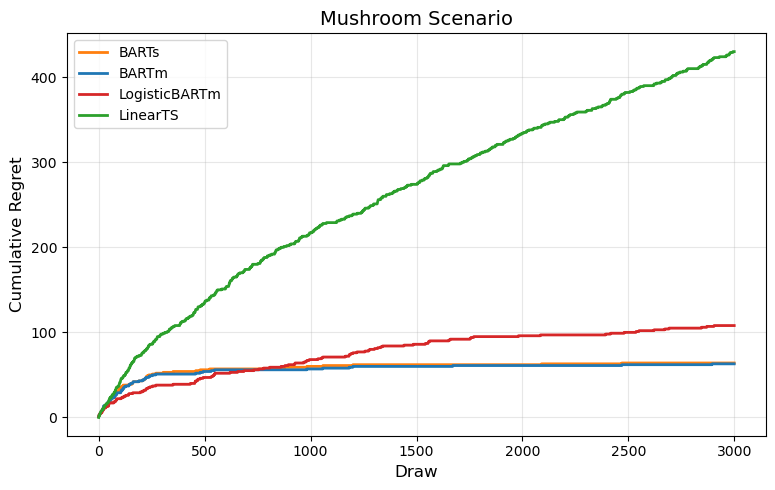

INFO bandit_simulator — Plot saved to ./results/compare_test_nb/agent_comparison_results_Mushroom.png


In [10]:
results = pickle.load(file=open(result_filename, "rb"))

# Plot results and save to file
plot_comparison_results(
    results=results,
    save_loc=f"{results_dir}/agent_comparison_results_{appendix_name}.png"
)
_ca_logger.info(f"Plot saved to {results_dir}/agent_comparison_results_{appendix_name}.png")